In [1]:
import numpy as np
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split # 더 정확한 평가를 위해서는 Stratified K-Fold 사용 추천

# Training

##### 모델 정의

In [2]:
# 가장 기본적인 구조를 제안드립니다. 
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
    def forward(self, last_hidden_state, attention_masks):
        input_mask_expanded = attention_masks.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class BertClassifier(nn.Module):
    def __init__(self, plm="snunlp/KR-FinBert-SC", num_classes=3):
        super(BertClassifier, self).__init__()
        self.num_classes = num_classes
        self.config = AutoConfig.from_pretrained(plm)
        self.bert = AutoModel.from_pretrained(plm)
        self.mean_pooler = MeanPooling() # mean-pooling (CLS-pooling보다 대체적으로 성능이 좋다)
        self.fcs = nn.Linear(self.config.hidden_size, self.num_classes)
    def forward(self, input_ids, attn_masks):
        x = self.bert(input_ids, attn_masks)[0]
        x = self.mean_pooler(x, attn_masks)
        x = self.fcs(x)
        return x

##### 예시 데이터 불러오기

이 예시 데이터를 사용했습니다: https://github.com/ukairia777/finance_sentiment_corpus/tree/main

In [3]:
df = pd.read_csv("finance_data.csv")

df.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [4]:
label_dict = {"neutral":2,
              "negative":1,
              "positive":0}

df["labels_encoded"] = df["labels"].apply(lambda x: label_dict[x])


In [5]:
df = df[["kor_sentence", "labels_encoded"]]

df.head()

,kor_sentence,labels_encoded
0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...",2
1,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,2
2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...",1
3,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,0
4,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...",0


<AxesSubplot: xlabel='labels_encoded', ylabel='count'>

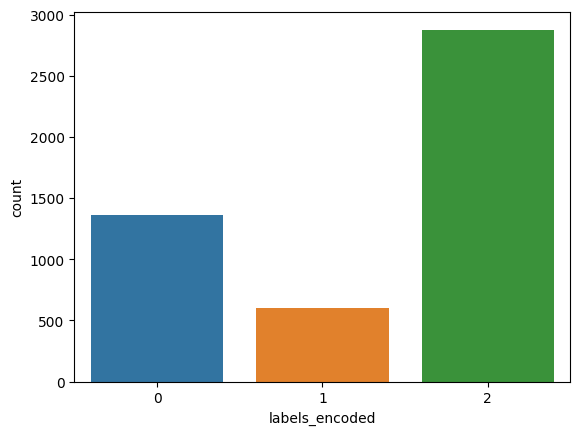

In [6]:
sns.countplot(df, x="labels_encoded") 

예시 데이터는 데이터 불균형이 심합니다. 이 예시에서는 단순하게 weighted cross entropy loss를 사용해서 임밸런스 문제를 해결하려고 시도해봅니다. 

# Train/Validation/Test Split

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels_encoded'], random_state=42)

val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['labels_encoded'], random_state=42) 

In [8]:
train_df.shape, val_df.shape, test_df.shape

((3876, 2), (485, 2), (485, 2))

##### 데이터 전처리

In [9]:
# 토크나이저 정의
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")

In [10]:
def preprocess_data(df):
    sentences = df["kor_sentence"].values
    labels = df["labels_encoded"].values
    input_ids, attn_masks = [], []
    for i in tqdm(range(len(sentences))):
        # 토큰 길이 적절히 조절 
        encoded_inputs = tokenizer(sentences[i], max_length=512, truncation=True, padding='max_length')
        input_ids.append(encoded_inputs["input_ids"])
        attn_masks.append(encoded_inputs["attention_mask"])
    input_ids = torch.tensor(input_ids, dtype=int)
    attn_masks = torch.tensor(attn_masks, dtype=int)
    labels = torch.tensor(labels, dtype=int)
    return input_ids, attn_masks, labels

In [11]:
train_input_ids, train_attn_masks, train_labels = preprocess_data(train_df) 
val_input_ids, val_attn_masks, val_labels = preprocess_data(val_df) 

  0%|          | 0/3876 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

In [12]:
# dataloader 정의
batch_size = 16
train_data = TensorDataset(train_input_ids, train_attn_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_input_ids, val_attn_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

##### Class Weight 계산

클래스 불균형이 있는 경우 class weight를 계산해서 이 정보를 loss를 계산할때 사용한다. 

In [13]:
def compute_inverse_freqs(targets, num_classes):
    class_counts = torch.bincount(targets, minlength=num_classes) 
    class_freqs = class_counts.float() / targets.size(0) 
    inverse_freqs = 1.0 / class_freqs 
    normalized_inv_freqs = inverse_freqs / sum(inverse_freqs) 
    return normalized_inv_freqs.tolist() 

In [14]:
alpha = compute_inverse_freqs(train_labels, 3) 
alpha = torch.tensor(alpha)

alpha

tensor([0.2681, 0.6050, 0.1269])

##### 모델 학습

In [15]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
alpha = alpha.to(device) 
loss_func = nn.CrossEntropyLoss(weight=alpha)

train_losses, train_accuracies, train_f1s = [], [], [] 
val_losses, val_accuracies, val_f1s = [], [], [] 
# loss값이 가장 좋은 체크포인트를 저장하는데, accuracy나 F1 기준으로도 저장할 수 있다. 
best_val_loss = np.inf

model.zero_grad()
for epoch in tqdm(range(epochs), desc="epochs", position=0, leave=True, total=epochs):
    train_loss, train_accuracy = 0, 0
    train_preds, train_true = [], [] 
    model.train()
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="training", position=0, leave=True):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attn_masks, b_labels = batch
        outputs = model(b_input_ids, b_attn_masks)
        loss = loss_func(outputs, b_labels)
        train_preds.extend(torch.argmax(outputs, axis=1).detach().cpu().numpy())
        train_true.extend(b_labels.detach().cpu().numpy())
        train_loss += loss.item()
        train_accuracy += flat_accuracy(outputs.detach().cpu().numpy(), b_labels.detach().cpu().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()
    train_f1 = f1_score(train_true, train_preds, average='weighted')
    train_f1s.append(train_f1)
    val_loss, val_accuracy = 0, 0
    val_preds, val_true = [], [] 
    model.eval()
    for step, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc="validating", position=0, leave=True):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attn_masks, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_masks)
        val_preds.extend(torch.argmax(outputs, axis=1).detach().cpu().numpy())
        val_true.extend(b_labels.detach().cpu().numpy())
        loss = loss_func(outputs, b_labels)
        val_loss += loss.item()
        val_accuracy += flat_accuracy(outputs.detach().cpu().numpy(), b_labels.detach().cpu().numpy())
    val_f1 = f1_score(val_true, val_preds, average='weighted')
    val_f1s.append(val_f1)
    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataloader)
    print(f"Epoch:{epoch+1} \n train loss: {avg_train_loss} | train accuracy: {avg_train_accuracy} | train F1: {train_f1} \n val loss: {avg_val_loss} | val accuracy: {avg_val_accuracy} | val F1: {val_f1}")
    train_losses.append(avg_train_loss) 
    train_accuracies.append(avg_train_accuracy) 
    val_losses.append(avg_val_loss) 
    val_accuracies.append(avg_val_accuracy) 
    if best_val_loss > avg_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"best_chkpt.pt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at snunlp/KR-FinBert-SC were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epochs:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/243 [00:00<?, ?it/s]

validating:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:1 
 train loss: 0.5822555541746901 | train accuracy: 0.7651748971193416 | train F1: 0.768120576187674 
 val loss: 0.5343556293556767 | val accuracy: 0.7491935483870968 | val F1: 0.7588533553424569


training:   0%|          | 0/243 [00:00<?, ?it/s]

validating:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:2 
 train loss: 0.3351131419770021 | train accuracy: 0.8685699588477366 | train F1: 0.8705172002837938 
 val loss: 0.46608976971718574 | val accuracy: 0.8100806451612903 | val F1: 0.8131418644876965


training:   0%|          | 0/243 [00:00<?, ?it/s]

validating:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:3 
 train loss: 0.20016696475783494 | train accuracy: 0.9323559670781894 | train F1: 0.9324862857468413 
 val loss: 0.5576468367249735 | val accuracy: 0.802016129032258 | val F1: 0.805385154156903


training:   0%|          | 0/243 [00:00<?, ?it/s]

validating:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:4 
 train loss: 0.11186868605614016 | train accuracy: 0.9609053497942387 | train F1: 0.9608596112412386 
 val loss: 0.8170243113511994 | val accuracy: 0.8383064516129033 | val F1: 0.8396470010117371


training:   0%|          | 0/243 [00:00<?, ?it/s]

validating:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:5 
 train loss: 0.07591653297094288 | train accuracy: 0.9768518518518519 | train F1: 0.9768236641255937 
 val loss: 0.9539960428711868 | val accuracy: 0.830241935483871 | val F1: 0.8321640745105705


##### 결과 분석 

In [17]:
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1) 
    plt.figure(figsize=(12, 6)) 
    plt.plot(epochs, train_loss, 'b', label='Train Loss') 
    plt.plot(epochs, val_loss, 'r', label='Valdiation Loss') 
    plt.title('Train and Validation Loss') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.legend()
    plt.show() 
    
def plot_accuracy(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1) 
    plt.figure(figsize=(12, 6)) 
    plt.plot(epochs, train_loss, 'b', label='Train Accuracy') 
    plt.plot(epochs, val_loss, 'r', label='Valdiation Accuracy') 
    plt.title('Train and Validation Accuracy') 
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.legend()
    plt.show() 
    
def plot_f1(train_loss, val_loss): 
    epochs = range(1, len(train_loss) + 1) 
    plt.figure(figsize=(12, 6)) 
    plt.plot(epochs, train_loss, 'b', label='Train F1') 
    plt.plot(epochs, val_loss, 'r', label='Valdiation F1') 
    plt.title('Train and Validation F1') 
    plt.xlabel('Epochs') 
    plt.ylabel('F1') 
    plt.legend()
    plt.show() 

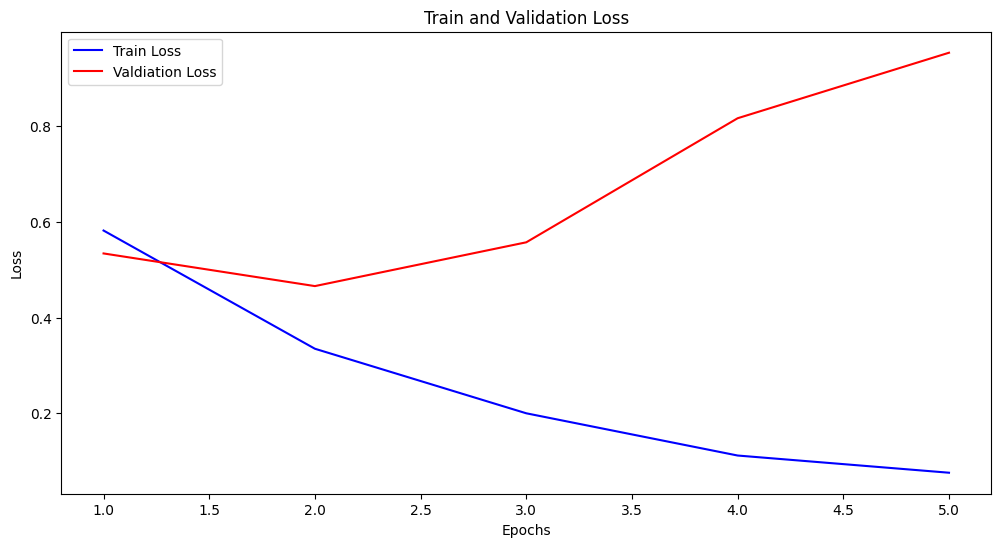

In [18]:
plot_loss(train_losses, val_losses) 

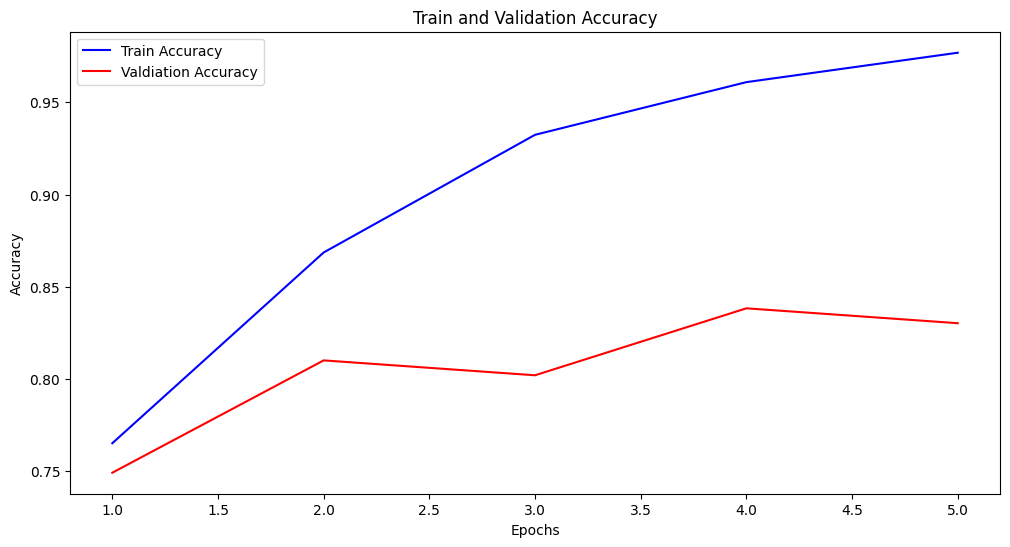

In [19]:
plot_accuracy(train_accuracies, val_accuracies)

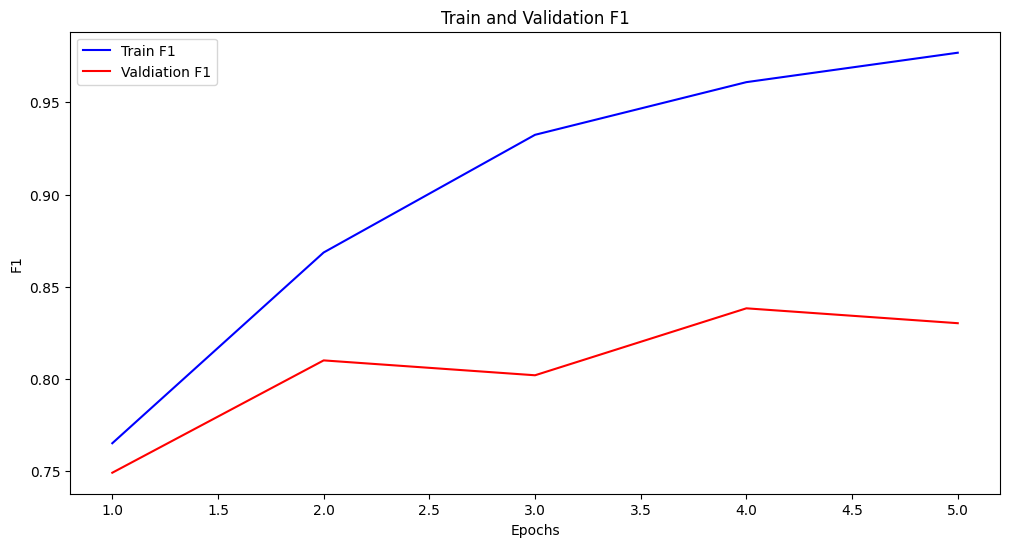

In [20]:
plot_f1(train_accuracies, val_accuracies)

# Inference

In [21]:
# 저장된 best checkpoint를 로드합니다. 
test_model = BertClassifier()
checkpoint = torch.load("best_chkpt.pt") 
print(test_model.load_state_dict(checkpoint))
test_model.to(device) 
test_model.eval() 
print() # 모델 로그 출력 생략 

Some weights of the model checkpoint at snunlp/KR-FinBert-SC were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>



batch 단위 inference

In [26]:
test_input_ids, test_attn_masks, test_labels = preprocess_data(test_df) 

test_data = TensorDataset(test_input_ids, test_attn_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

  0%|          | 0/485 [00:00<?, ?it/s]

In [27]:
test_labels = test_labels.numpy()

In [32]:
predictions = [] 

for batch in tqdm(test_dataloader, desc="inference"):
    batch = (t.to(device) for t in batch) 
    b_input_ids, b_attn_masks = batch 
    with torch.no_grad():
        outputs = test_model(b_input_ids, b_attn_masks) 
    for i in range(outputs.shape[0]):
        probs = outputs[i].detach().cpu().numpy() 
        predictions.append(np.argmax(probs)) 
    

inference:   0%|          | 0/31 [00:00<?, ?it/s]

In [36]:
# accuracy 계산 
cnt = 0 
for i in range(len(predictions)):
    if predictions[i] == test_labels[i]:
        cnt += 1
        
accuracy = cnt / len(predictions) * 100 

print(f"test accuracy = {accuracy}%")

test accuracy = 80.82474226804123%


In [38]:
inv_label_dict = {2: "neutral", 
                  1: "negative", 
                  0: "positive"}

In [39]:
# print a few samples 
test_sentences = test_df["kor_sentence"].values 
for i in range(10):
    print(f"테스트 샘플 {i+1}") 
    print(test_sentences[i]) 
    print(f"예측된 레이블: {inv_label_dict[predictions[i]]}") 
    print(f"실제 레이블: {inv_label_dict[test_labels[i]]}")
    print()
    print()

테스트 샘플 1
ADP 뉴스 - 2009년 4월 22일 - 핀란드 비즈니스 정보 시스템 개발업체 Solteq Oyj HEL: STQ1V는 오늘 2009년 1/4분기 순손실이 같은 기간의 10,000유로에서 189,000유로 245,000유로로 확대되었다고 밝혔습니다.
예측된 레이블: negative
실제 레이블: negative


테스트 샘플 2
GSK는 2008년 11월 다트포드에 있는 사업장을 폐쇄할 것이라고 발표했다.
예측된 레이블: neutral
실제 레이블: negative


테스트 샘플 3
계약은 로그 핸들링 라인, 필링 라인, 베니어 건조 및 그레이딩 라인으로 구성됩니다.
예측된 레이블: neutral
실제 레이블: neutral


테스트 샘플 4
인도의 러시아와의 교역은 현재 40억 달러로 2007 회계연도에 9.6% 성장했다.
예측된 레이블: positive
실제 레이블: positive


테스트 샘플 5
Stora Enso Oyj는 2분기 실적이 2007년 같은 기간에 비해 절반으로 떨어질 것이라고 말했다.
예측된 레이블: negative
실제 레이블: negative


테스트 샘플 6
이에따라 양당은 아베나를 협상 대상에서 제외하기로 합의했다.
예측된 레이블: neutral
실제 레이블: neutral


테스트 샘플 7
EPS 지수는 유로0.27에서 유로0.38로 개선되었다.
예측된 레이블: positive
실제 레이블: positive


테스트 샘플 8
7월 11일 버지니아주 알렉산드리아 - 핀란드 유카에 사는 한누 카호넨이 방화구 손잡이 장식 디자인을 개발했다고 미국 특허청이 발표했다.
예측된 레이블: neutral
실제 레이블: neutral


테스트 샘플 9
시티24 이용자들은 시티24가 활동 중인 모든 지역의 주택과 사유지를 자신의 나라 밖에서도 검색할 수 있다.
예측된 레이블: neutral
실제 레이블: neutral


테스트 샘플 10
그 회사는 2008년에 주당 0.12유로의 배당을 제안할 것이다.
예측된 레